In [79]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("deep")

In [80]:
columns = ["COD_HOSPITAL"
,"CIP_ENCRIPTADO"
,"SEXO"
,"FECHA_NACIMIENTO"
,"PROVINCIA"
,"COMUNA"
,"NACIONALIDAD"
,"PREVISION"
,"SERVICIO_SALUD"
,"TIPO_PROCEDENCIA"
,"TIPO_INGRESO"
,"ESPECIALIDAD_MEDICA"
,"TIPO_ACTIVIDAD"
,"FECHA_INGRESO"
,"SERVICIOINGRESO"
,"FECHAALTA"
,"SERVICIOALTA"
,"TIPOALTA"
,"DIAGNOSTICO1"
,"DIAGNOSTICO2"
,"DIAGNOSTICO3"
,"DIAGNOSTICO4"
,"DIAGNOSTICO5"
,"DIAGNOSTICO6"
,"DIAGNOSTICO7"
,"DIAGNOSTICO8"
,"DIAGNOSTICO9"
,"DIAGNOSTICO10"
,"PROCEDIMIENTO1"
,"PROCEDIMIENTO2"
,"PROCEDIMIENTO3"
,"PROCEDIMIENTO4"
,"PROCEDIMIENTO5"
,"PROCEDIMIENTO6"
,"PROCEDIMIENTO7"
,"PROCEDIMIENTO8"
,"PROCEDIMIENTO9"
,"PROCEDIMIENTO10"
,"USOSPABELLON"
,"IR_29301_COD_GRD"
,"IR_29301_PESO"]

In [81]:
data = pd.read_csv(r'Datos\GRD_PUBLICO_2023.csv',sep='|',engine='python',encoding='utf-16', usecols=columns, na_values=["DESCONOCIDO"])

In [82]:
for col in ['FECHAALTA','FECHA_INGRESO','FECHA_NACIMIENTO']:
    data[col] = pd.to_datetime(data[col], errors='coerce')

C:\Users\benjo\AppData\Local\Temp\ipykernel_28860\3839240850.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [83]:
data.dropna(subset=['FECHA_INGRESO','FECHAALTA', 'FECHA_NACIMIENTO','PROVINCIA'], inplace=True, how='any')

In [84]:
date_cols = data[["FECHAALTA", "FECHA_INGRESO"]].copy()

for idx, row in date_cols.iterrows():
    if row['FECHAALTA'] < row['FECHA_INGRESO']:
        data.at[idx, 'FECHAALTA'], data.at[idx, 'FECHA_INGRESO'] = row['FECHA_INGRESO'], row['FECHAALTA']

In [85]:
data["DIAS_ESTANCIA"] = (data["FECHAALTA"] - data["FECHA_INGRESO"]).dt.days
data["EDAD"] = (data["FECHAALTA"] - data["FECHA_NACIMIENTO"]).dt.days // 365

In [141]:
bins = [0, 18, 40, 65, 100]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

data["Rango_Etario"] = pd.cut(data["EDAD"], bins = bins, labels=labels, right=False)

In [142]:
data["IR_29301_PESO"] = data["IR_29301_PESO"].apply(lambda x: float(".".join(x.split(','))) if type(x) == str else x)

In [143]:
data.count()

COD_HOSPITAL           363691
CIP_ENCRIPTADO         363122
SEXO                   363673
FECHA_NACIMIENTO       363691
PROVINCIA              363691
COMUNA                 363691
NACIONALIDAD           363691
PREVISION              363679
SERVICIO_SALUD         363534
TIPO_PROCEDENCIA       363690
TIPO_INGRESO           363681
ESPECIALIDAD_MEDICA    363691
TIPO_ACTIVIDAD         363691
FECHA_INGRESO          363691
SERVICIOINGRESO        361377
FECHAALTA              363691
SERVICIOALTA           361556
TIPOALTA               363691
DIAGNOSTICO1           363691
DIAGNOSTICO2           311430
DIAGNOSTICO3           263461
DIAGNOSTICO4           215232
DIAGNOSTICO5           169292
DIAGNOSTICO6           130504
DIAGNOSTICO7            99205
DIAGNOSTICO8            74593
DIAGNOSTICO9            56008
DIAGNOSTICO10           42002
PROCEDIMIENTO1         363614
PROCEDIMIENTO2         333453
PROCEDIMIENTO3         300274
PROCEDIMIENTO4         269637
PROCEDIMIENTO5         240587
PROCEDIMIE

In [144]:
comuna = ['ANTÁRTICA']
SERVICIO_SALUD = ['AISEN','MAGALLANES','CHILOE','COIHAIQUE']
cie10_codigos_cancer = []
#cie10_codigos_cancer = ["C00", "C01", "C02", "C03", "C04", "C05", "C06", "C07", "C08", "C09", "C10", "C11", "C12", "C13", "C14","C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26","C30", "C31", "C32", "C33", "C34", "C37", "C38", "C39","C40", "C41","C43", "C44","C45", "C46", "C47", "C48", "C49","C50","C51", "C52", "C53", "C54", "C55", "C56", "C57", "C58","C60", "C61", "C62", "C63","C64", "C65", "C66", "C67", "C68","C69", "C70", "C71", "C72","C73", "C74", "C75","C76", "C77", "C78", "C79", "C80","C81", "C82", "C83", "C84", "C85", "C86", "C88","C90", "C91", "C92", "C93", "C94", "C95","C96", "C97"]

In [145]:
data["PROVINCIA"].value_counts().loc[SERVICIO_SALUD]

KeyError: "None of [Index(['AISEN', 'MAGALLANES', 'CHILOE', 'COIHAIQUE'], dtype='object', name='PROVINCIA')] are in the [index]"

In [146]:
diagnostico_cols = [f"DIAGNOSTICO{i}" for i in range(1, 11)]

tiene_cancer = data[diagnostico_cols].isin(cie10_codigos_cancer).any(axis=1)

condicion = (
    data["COMUNA"].isin(comuna) |
    data["PROVINCIA"].isin(SERVICIO_SALUD) |
    tiene_cancer
)

data = data[~condicion]


In [147]:
data = data[~data["PROVINCIA"].isin(SERVICIO_SALUD)]

In [148]:
data.count()

COD_HOSPITAL           363691
CIP_ENCRIPTADO         363122
SEXO                   363673
FECHA_NACIMIENTO       363691
PROVINCIA              363691
COMUNA                 363691
NACIONALIDAD           363691
PREVISION              363679
SERVICIO_SALUD         363534
TIPO_PROCEDENCIA       363690
TIPO_INGRESO           363681
ESPECIALIDAD_MEDICA    363691
TIPO_ACTIVIDAD         363691
FECHA_INGRESO          363691
SERVICIOINGRESO        361377
FECHAALTA              363691
SERVICIOALTA           361556
TIPOALTA               363691
DIAGNOSTICO1           363691
DIAGNOSTICO2           311430
DIAGNOSTICO3           263461
DIAGNOSTICO4           215232
DIAGNOSTICO5           169292
DIAGNOSTICO6           130504
DIAGNOSTICO7            99205
DIAGNOSTICO8            74593
DIAGNOSTICO9            56008
DIAGNOSTICO10           42002
PROCEDIMIENTO1         363614
PROCEDIMIENTO2         333453
PROCEDIMIENTO3         300274
PROCEDIMIENTO4         269637
PROCEDIMIENTO5         240587
PROCEDIMIE

In [149]:
data.describe()

,COD_HOSPITAL,CIP_ENCRIPTADO,FECHA_NACIMIENTO,FECHA_INGRESO,FECHAALTA,PROCEDIMIENTO1,PROCEDIMIENTO2,PROCEDIMIENTO3,PROCEDIMIENTO4,PROCEDIMIENTO5,...,PROCEDIMIENTO7,PROCEDIMIENTO8,PROCEDIMIENTO9,PROCEDIMIENTO10,USOSPABELLON,IR_29301_COD_GRD,IR_29301_PESO,DIAS_ESTANCIA,EDAD,Cardiovascular
count,363691.000000,3.631220e+05,363691,363691,363691,363614.000000,333453.000000,300274.000000,269637.000000,240587.000000,...,183751.000000,155949.000000,129164.000000,104848.000000,217831.000000,363691.000000,363691.000000,363691.000000,363691.000000,363691.000000
mean,113265.413975,7.843097e+07,1979-03-10 11:49:43.876972480,2023-04-27 16:02:18.816742400,2023-08-22 01:37:27.170263040,69.408344,77.324417,84.902603,87.763867,89.369134,...,90.351287,90.258634,90.231614,90.108626,1.331881,92298.828775,0.732133,116.399402,43.991399,0.139363
min,101100.000000,6.698809e+07,1918-10-04 00:00:00,2022-01-11 00:00:00,2023-01-01 00:00:00,0.090000,0.030000,0.010000,0.010000,0.090000,...,0.090000,0.120000,0.120000,0.090000,0.000000,11111.000000,0.000000,0.000000,0.000000,0.000000
25%,109100.000000,7.081438e+07,1957-02-15 00:00:00,2023-02-11 00:00:00,2023-07-01 00:00:00,51.230000,73.600000,88.010000,88.790000,89.480000,...,89.540000,89.590000,89.590000,89.590000,1.000000,51402.000000,0.439300,49.000000,25.000000,0.000000
50%,113180.000000,7.528972e+07,1980-03-29 00:00:00,2023-04-11 00:00:00,2023-09-06 00:00:00,76.460000,88.410000,90.590000,90.930000,91.390000,...,91.390000,91.390000,91.390000,91.330000,1.000000,81601.000000,0.658000,108.000000,43.000000,0.000000
75%,118100.000000,8.190040e+07,1998-04-13 00:00:00,2023-07-04 00:00:00,2023-11-06 00:00:00,88.720000,93.960000,99.210000,99.210000,99.210000,...,99.190000,99.190000,99.180000,99.170000,1.000000,132340.000000,0.961600,176.000000,66.000000,0.000000
max,133150.000000,1.008360e+08,2023-12-12 00:00:00,2023-12-12 00:00:00,2023-12-31 00:00:00,99.990000,99.990000,99.990000,99.990000,99.990000,...,99.990000,99.990000,99.990000,99.990000,8.000000,990129.000000,1.866800,366.000000,104.000000,1.000000
std,6436.729802,1.006624e+07,NaN,NaN,NaN,26.111590,27.158391,22.782633,19.614856,16.855881,...,14.703715,14.741979,14.344364,14.304942,0.744722,63662.955666,0.366818,82.520863,25.559566,0.346325


In [150]:
enfermedades_cardiovasculares = ['I01', 'I05', 'I06', 'I07', 'I08', 'I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45', 'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I60', 'I61', 'I62', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72', 'I73', 'I74', 'I75', 'I76', 'I77', 'I78', 'I79', 'I80', 'I81', 'I82', 'I83', 'I84', 'I85', 'I86', 'I87', 'I88', 'I89', 'I95', 'I96', 'I97', 'I98', 'I99', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28']


In [151]:
data['Cardiovascular'] = (data[data[["DIAGNOSTICO1", "DIAGNOSTICO2", "DIAGNOSTICO3"]].isin(enfermedades_cardiovasculares)].notnull().sum(axis=1) > 0).astype(int)

In [152]:
data_cardio = data[data['Cardiovascular'] == 1]
data_cardio = data_cardio.dropna(subset=['DIAS_ESTANCIA', 'EDAD'], how='any')
data_no_cardio = data[data['Cardiovascular'] == 0]
data_cardio = data_no_cardio.dropna(subset=['DIAS_ESTANCIA', 'EDAD'], how='any')

In [153]:
dataog = data.copy()

In [154]:
def no_outliers(data, column):
    print(column)
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [155]:
datasave = data.copy()

In [156]:
for column in ["DIAS_ESTANCIA", "IR_29301_PESO"]:
    data = no_outliers(data, column)
print((dataog.count() - data.count())/ dataog.count())


DIAS_ESTANCIA
IR_29301_PESO
COD_HOSPITAL           0.007754
CIP_ENCRIPTADO         0.007752
SEXO                   0.007754
FECHA_NACIMIENTO       0.007754
PROVINCIA              0.007754
COMUNA                 0.007754
NACIONALIDAD           0.007754
PREVISION              0.007754
SERVICIO_SALUD         0.007754
TIPO_PROCEDENCIA       0.007754
TIPO_INGRESO           0.007754
ESPECIALIDAD_MEDICA    0.007754
TIPO_ACTIVIDAD         0.007754
FECHA_INGRESO          0.007754
SERVICIOINGRESO        0.007784
FECHAALTA              0.007754
SERVICIOALTA           0.007791
TIPOALTA               0.007754
DIAGNOSTICO1           0.007754
DIAGNOSTICO2           0.008933
DIAGNOSTICO3           0.010051
DIAGNOSTICO4           0.011295
DIAGNOSTICO5           0.012605
DIAGNOSTICO6           0.013931
DIAGNOSTICO7           0.014566
DIAGNOSTICO8           0.014774
DIAGNOSTICO9           0.014748
DIAGNOSTICO10          0.014523
PROCEDIMIENTO1         0.007755
PROCEDIMIENTO2         0.008355
PROCEDIMIENT

<Axes: xlabel='IR_29301_PESO', ylabel='Count'>

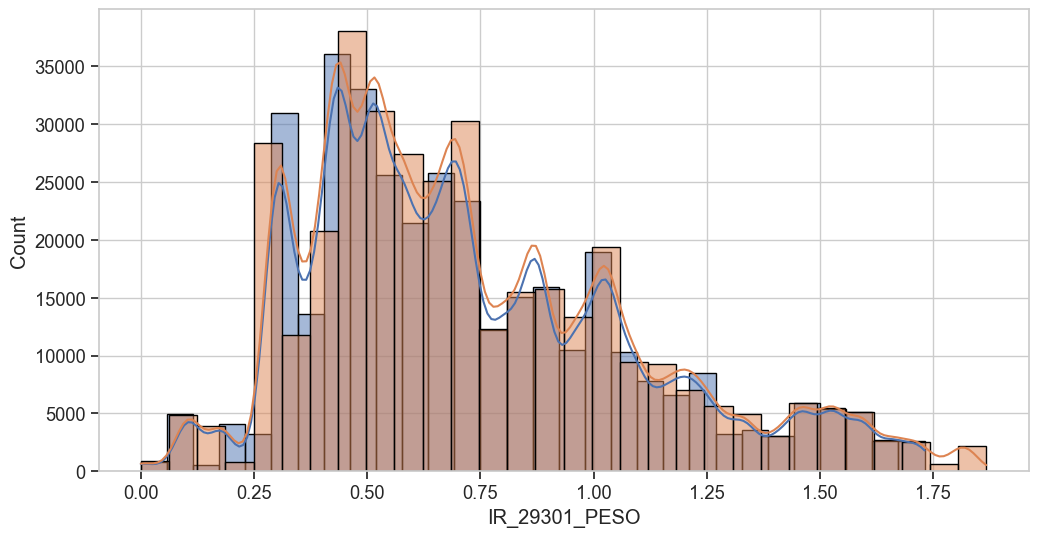

In [157]:
sns.histplot(data['IR_29301_PESO'], bins=30, kde=True)
sns.histplot(dataog['IR_29301_PESO'], bins=30, kde=True)

<Axes: xlabel='IR_29301_PESO', ylabel='Count'>

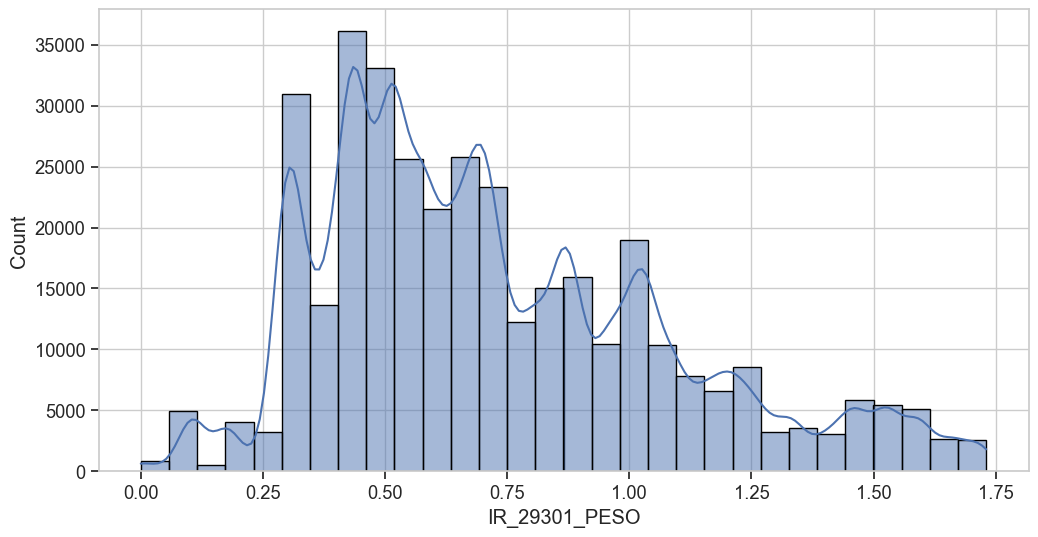

In [158]:
sns.histplot(data['IR_29301_PESO'], bins=30, kde=True)

- **Pregunta secundaria 1:** ¿Existe una relación significativa entre el costo y la edad de los pacientes?
- **Pregunta secundaria 2:** ¿Como distribuyen las personas con multimorbilidad en relación al costo?
- **Pregunta secundaria 3:** ¿Existen regiones cuyos costos sean diferentes en comparación al país?


<Axes: xlabel='Rango_Etario', ylabel='Count'>

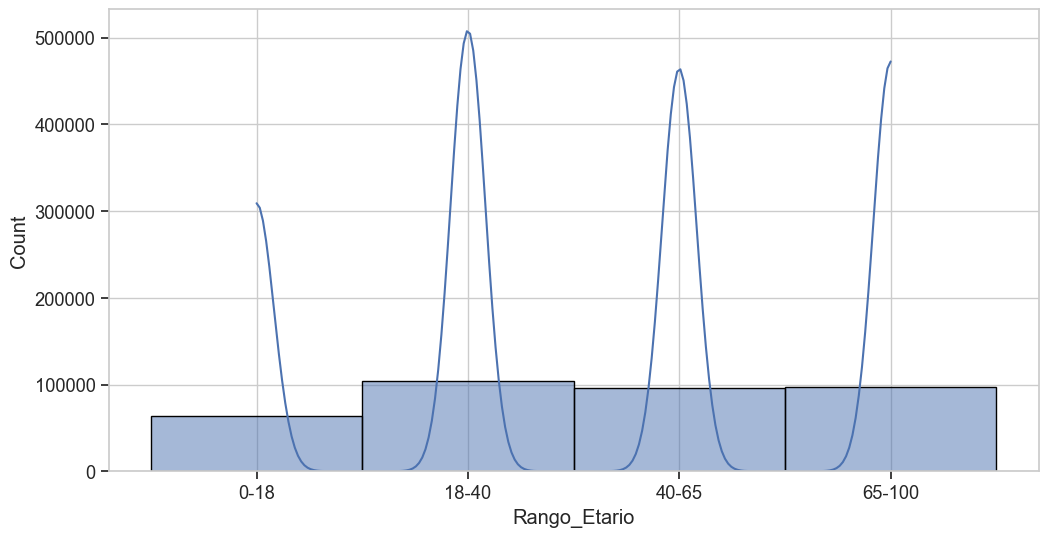

In [159]:
sns.histplot(data['Rango_Etario'], bins=30, kde=True)

In [202]:
#¿Existe una relación significativa entre el costo y la edad de los pacientes?
#H0: No existe relación significativa entre el costo y la edad de los pacientes
#H1: Existe relación significativa entre el costo y la edad de los pacientes
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
correlation, p_value = stats.pearsonr(data_cardio['IR_29301_PESO'], data_cardio['EDAD'])
print(f"Correlation: {correlation}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una relación significativa entre el costo y la edad de los pacientes")
else:
    print("No se rechaza la hipótesis nula, no existe una relación significativa entre el costo y la edad de los pacientes")


Correlation: 0.28086421070821793, P-value: 0.0
Rechazamos la hipótesis nula, existe una relación significativa entre el costo y la edad de los pacientes


In [203]:
#Existe una relacion entre la edad y los dias de estancia con enfermedades cardiovasculares?
#H0: No existe relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares
#H1: Existe relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
correlation, p_value = stats.pearsonr(data_cardio['DIAS_ESTANCIA'], data_cardio['EDAD'])
print(f"Correlation: {correlation}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares")
else:
    print("No se rechaza la hipótesis nula, no existe una relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares")

Correlation: 0.014732856905779938, P-value: 1.6794992804047223e-16
Rechazamos la hipótesis nula, existe una relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares


In [204]:
#Existe una relacion entre dias de estancia y costo con enfermedades cardiovasculares?
#H0: No existe relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares
#H1: Existe relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
correlation, p_value = stats.pearsonr(data_cardio['DIAS_ESTANCIA'], data_cardio['IR_29301_PESO'])
print(f"Correlation: {correlation}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares")
else:
    print("No se rechaza la hipótesis nula, no existe una relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares")

Correlation: 0.00226326786607787, P-value: 0.20543230303234544
No se rechaza la hipótesis nula, no existe una relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares


In [162]:
#¿Como distribuyen las personas con enfermedades Cardiovasculares en relación al costo?
#H0: No existe relación significativa entre el costo y la multimorbilidad
#H1: Existe relación significativa entre el costo y la multimorbilidad
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables

# Crear nuevo DataFrame para A/B test: grupo_con = cardiovascular, grupo_sin = sin cardiovascular
df_ab_cardio = data[data['IR_29301_PESO'].notnull()].copy()
df_ab_cardio['grupo'] = df_ab_cardio['Cardiovascular'].map({0: 'Sin_Cardio', 1: 'Con_Cardio'})

grupo_sin = df_ab_cardio[df_ab_cardio['grupo'] == 'Sin_Cardio']['IR_29301_PESO']
grupo_con = df_ab_cardio[df_ab_cardio['grupo'] == 'Con_Cardio']['IR_29301_PESO']



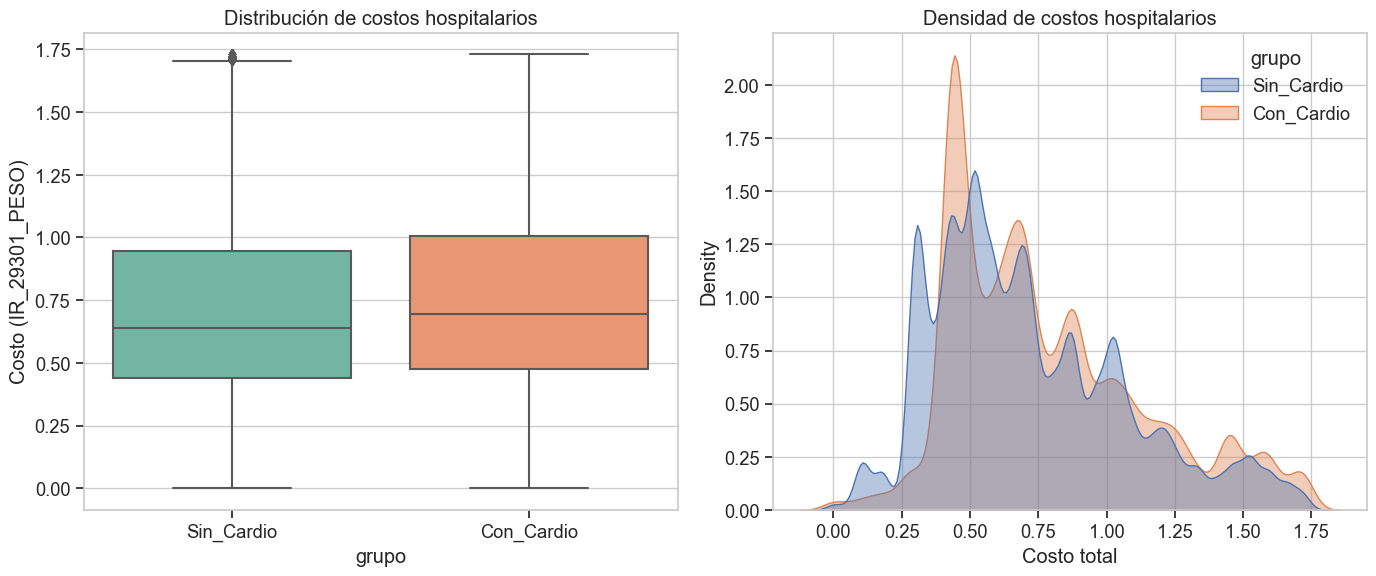

In [163]:
plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=df_ab_cardio, x='grupo', y='IR_29301_PESO', palette='Set2')
plt.title('Distribución de costos hospitalarios')
plt.ylabel('Costo (IR_29301_PESO)')

# KDE Plot
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_ab_cardio, x='IR_29301_PESO', hue='grupo', fill=True, common_norm=False, alpha=0.4)
plt.title('Densidad de costos hospitalarios')
plt.xlabel('Costo total')

plt.tight_layout()
plt.show()


In [164]:
t_stat, p_valor = stats.ttest_ind(grupo_con, grupo_sin, equal_var=False)

# Estadísticas descriptivas
stats_grupos = df_ab_cardio.groupby('grupo')['IR_29301_PESO'].agg(['count', 'mean', 'std', 'median'])
print("Estadísticas descriptivas por grupo:")
print(stats_grupos)

# Resultados
print(f"\nResultados de la prueba A/B (Costos Cardiovasculares):")
print(f"Estadístico t: {t_stat:.4f}")
print(f"Valor p: {p_valor:.4f}")

alpha = 0.05
if p_valor < alpha:
    print(f"➡️ Diferencia estadísticamente significativa (p < {alpha})")
    diff = stats_grupos.loc['Con_Cardio', 'mean'] - stats_grupos.loc['Sin_Cardio', 'mean']
    print(f"Diferencia media en el costo: ${diff:,.2f}")
else:
    print(f"❌ No se encuentra diferencia estadísticamente significativa (p ≥ {alpha})")


Estadísticas descriptivas por grupo:
             count      mean       std  median
grupo                                         
Con_Cardio   49990  0.781552  0.359136  0.6940
Sin_Cardio  310881  0.714404  0.354135  0.6406

Resultados de la prueba A/B (Costos Cardiovasculares):
Estadístico t: 38.8748
Valor p: 0.0000
➡️ Diferencia estadísticamente significativa (p < 0.05)
Diferencia media en el costo: $0.07


In [165]:
efecto = (grupo_con.mean() - grupo_sin.mean()) / np.sqrt((grupo_con.std()**2 + grupo_sin.std()**2) / 2)
print(f"\nTamaño del efecto (d de Cohen): {efecto:.3f}")
if abs(efecto) < 0.2:
    print("Efecto pequeño")
elif abs(efecto) < 0.5:
    print("Efecto mediano")
else:
    print("Efecto grande")



Tamaño del efecto (d de Cohen): 0.188
Efecto pequeño


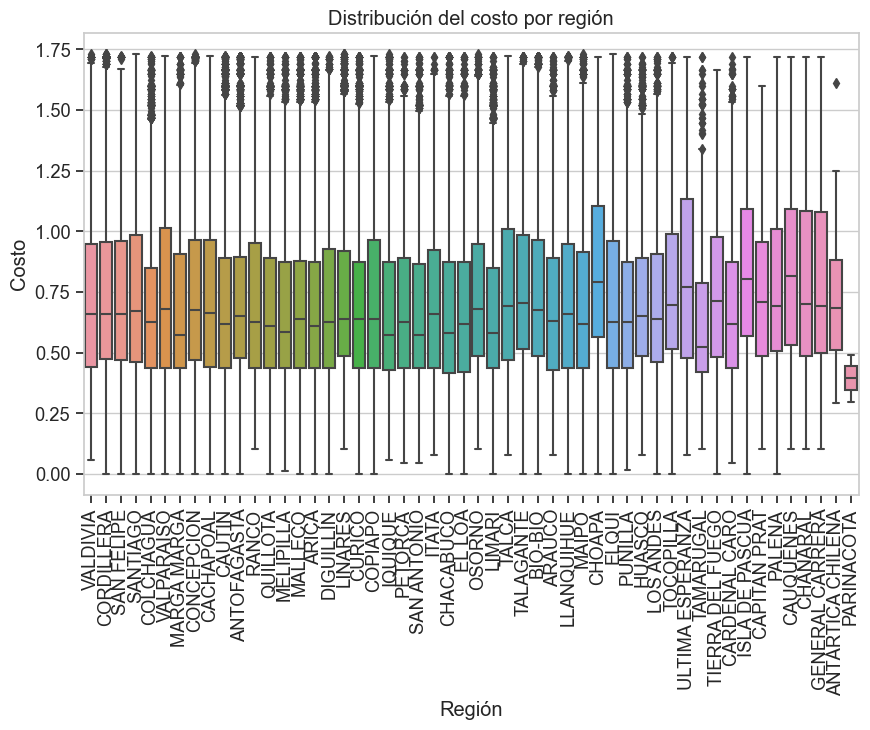

In [166]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='PROVINCIA', y='IR_29301_PESO')
plt.title('Distribución del costo por región')
plt.xticks(rotation=90)
plt.xlabel('Región')
plt.ylabel('Costo')
plt.show()

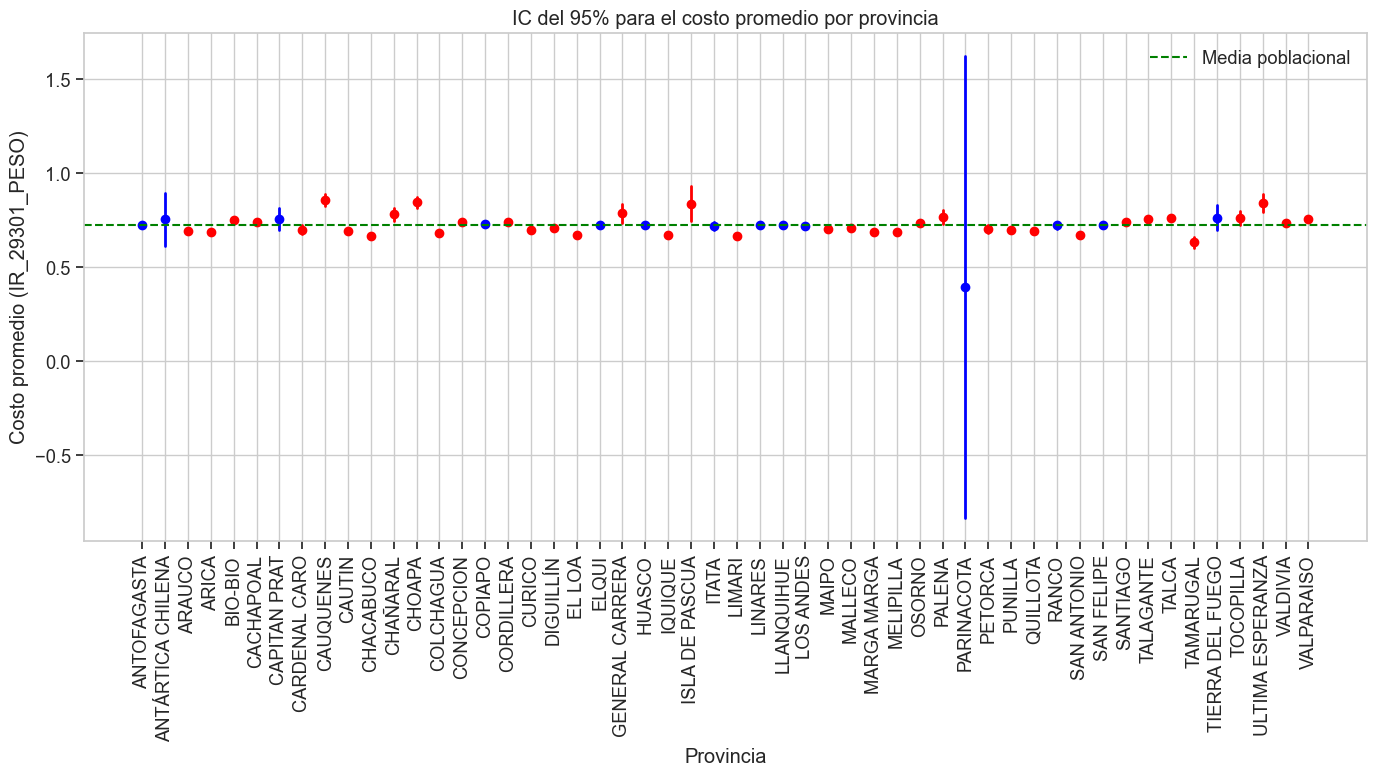

In [167]:

media_poblacional = data['IR_29301_PESO'].mean()
provincias = data['PROVINCIA'].unique()
provincias.sort()

intervalos = []
medias = []
labels = []
colores = []

n_min = data['PROVINCIA'].value_counts().min()

for prov in provincias:
    subset = data[data['PROVINCIA'] == prov]['IR_29301_PESO'].dropna()
    n = len(subset)

    if n >= n_min:
        media = np.mean(subset)
        std = np.std(subset, ddof=1)
        error_estandar = std / np.sqrt(n)
        valor_t = stats.t.ppf(0.975, n - 1)
        margen_error = valor_t * error_estandar

        intervalo_inf = media - margen_error
        intervalo_sup = media + margen_error

        contiene = intervalo_inf <= media_poblacional <= intervalo_sup
        color = 'blue' if contiene else 'red'

        intervalos.append((intervalo_inf, intervalo_sup))
        medias.append(media)
        labels.append(prov)
        colores.append(color)

plt.figure(figsize=(14, 8))

for i, (media, (inf, sup), color) in enumerate(zip(medias, intervalos, colores)):
    plt.plot([i, i], [inf, sup], color=color, linewidth=2)
    plt.plot(i, media, 'o', color=color)

plt.axhline(y=media_poblacional, color='green', linestyle='--', label='Media poblacional')

plt.xticks(range(len(labels)), labels, rotation=90)
plt.xlabel('Provincia')
plt.ylabel('Costo promedio (IR_29301_PESO)')
plt.title('IC del 95% para el costo promedio por provincia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [168]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

modelo = ols('IR_29301_PESO ~ C(PROVINCIA)', data=data).fit()
anova = sm.stats.anova_lm(modelo, typ=2)
print(anova)


                    sum_sq        df          F  PR(>F)
C(PROVINCIA)    262.451398      51.0  40.928578     0.0
Residual      45367.146326  360819.0        NaN     NaN


In [169]:
grupos = [grupo['IR_29301_PESO'].dropna() for _, grupo in data.groupby('PROVINCIA')]

#ANOVA
f_stat, p_value = stats.f_oneway(*grupos)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Rechazamos H0: Al menos una región tiene un costo significativamente diferente al promedio nacional.")
else:
    print("No se rechaza H0: No hay evidencia suficiente para afirmar diferencias entre regiones.")


F-statistic: 40.92857756840529, P-value: 0.0
Rechazamos H0: Al menos una región tiene un costo significativamente diferente al promedio nacional.


In [170]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=data['IR_29301_PESO'],
                          groups=data['PROVINCIA'],
                          alpha=0.05)
print(tukey)


           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
      ANTOFAGASTA ANTÁRTICA CHILENA   0.0324    1.0 -0.2647  0.3294  False
      ANTOFAGASTA            ARAUCO  -0.0297 0.0394 -0.0588 -0.0005   True
      ANTOFAGASTA             ARICA  -0.0362    0.0 -0.0603 -0.0122   True
      ANTOFAGASTA           BIO-BIO   0.0284 0.0002  0.0065  0.0504   True
      ANTOFAGASTA         CACHAPOAL   0.0203 0.2305 -0.0028  0.0433  False
      ANTOFAGASTA      CAPITAN PRAT   0.0332    1.0 -0.0957  0.1621  False
      ANTOFAGASTA     CARDENAL CARO  -0.0216    1.0 -0.0705  0.0273  False
      ANTOFAGASTA         CAUQUENES   0.1347    0.0  0.0735  0.1959   True
      ANTOFAGASTA            CAUTIN  -0.0287    0.0 -0.0492 -0.0082   True
      ANTOFAGASTA         CHACABUCO  -0.0551    0.0 -0.0845 -0.0257   True
      ANTOFAGASTA        

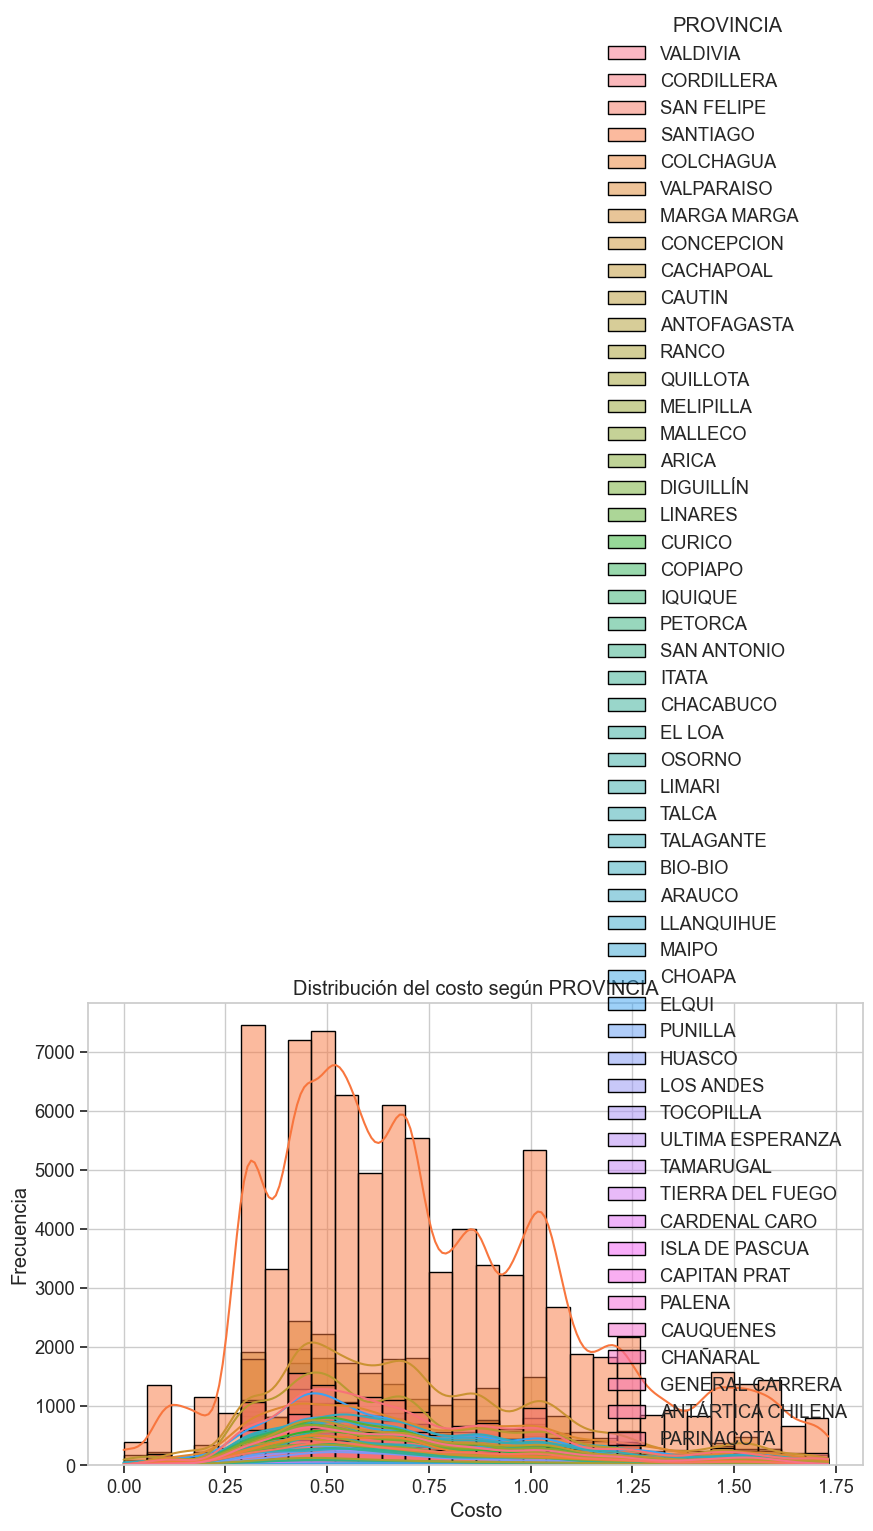

In [171]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='IR_29301_PESO', hue='PROVINCIA', kde=True, bins=30)
plt.title('Distribución del costo según PROVINCIA')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')
plt.show()

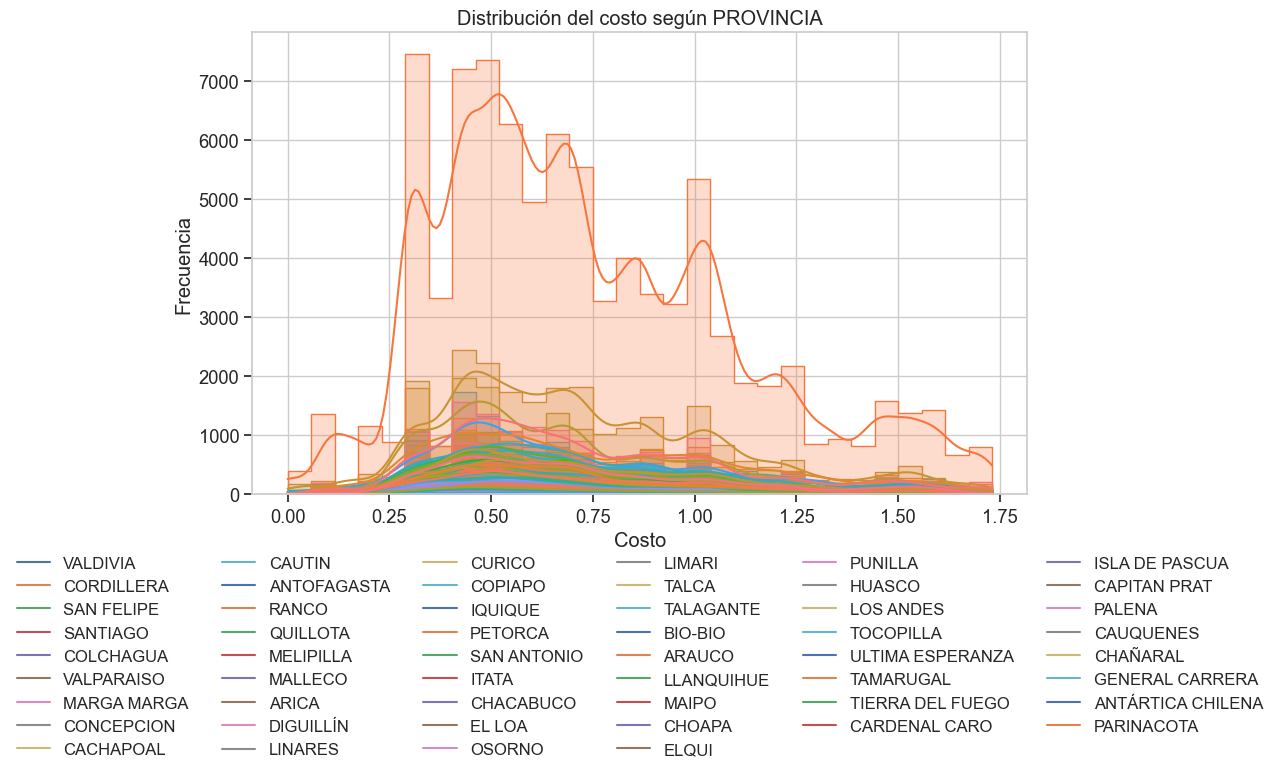

In [172]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='IR_29301_PESO', hue='PROVINCIA', kde=True, bins=30, element='step', legend=True)
plt.title('Distribución del costo según PROVINCIA')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')

unique_labels = list(data['PROVINCIA'].unique())
palette = sns.color_palette(n_colors=len(unique_labels))

handles = [Line2D([0], [0], color=palette[i]) for i in range(len(unique_labels))]

ax.legend(handles=handles, labels=unique_labels, ncol=6, fontsize='small', loc='upper center', bbox_to_anchor=(0.5, -0.1))

plt.show()

T-statistic: -38.874765732451976, P-value: 0.0
Rechazamos la hipótesis nula, existe una diferencia significativa en el costo entre personas con y sin enfermedades cardiovasculares.


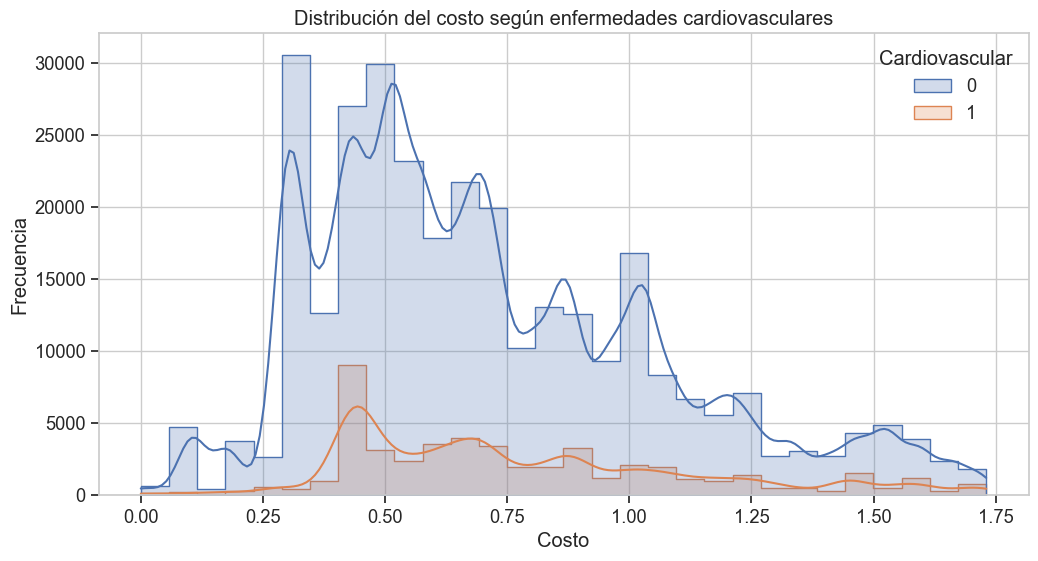

In [173]:
#eje x la edad
#en el eje y el peso medio
#dos curvas peso medio con weas cardiacas y la otra es peso medio sin weas cardiacas
#Como se distribuyen los csotos y las edades con pacientes con y sin enfermedades cardiacas
#¿Como distribuyen las personas con enfermedades cardiacas en relación al costo?
#H0: No existe relación significativa entre el costo y la enfermedad cardiaca
#H1: Existe relación significativa entre el costo y la enfermedad cardiaca
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
grupo_sin = data[data['Cardiovascular'] == 0]['IR_29301_PESO']
grupo_con = data[data['Cardiovascular'] == 1]['IR_29301_PESO']
t_stat, p_value = stats.ttest_ind(grupo_sin, grupo_con, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una diferencia significativa en el costo entre personas con y sin enfermedades cardiovasculares.")
else:
    print("No se rechaza la hipótesis nula, no existe una diferencia significativa en el costo entre personas con y sin enfermedades cardiovasculares.")
sns.histplot(data=data, x='IR_29301_PESO', hue='Cardiovascular', kde=True, bins=30, element='step')
plt.title('Distribución del costo según enfermedades cardiovasculares')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')
plt.show()



In [174]:
def Lowess_plot_cardiovascular(df, column1, column2, frac=0.2):
    for cardiopatia, color, label in zip([0, 1], ['blue', 'orange'], ['No', 'Sí']):
        subset = df[df['Cardiovascular'] == cardiopatia]
        x = subset[column1]
        y = subset[column2]

        lowess_result = sm.nonparametric.lowess(y, x, frac)
        x_lowess, y_lowess = lowess_result[:, 0], lowess_result[:, 1]

        plt.plot(x_lowess, y_lowess, label=f'Cardiopatía: {label}', color=color)

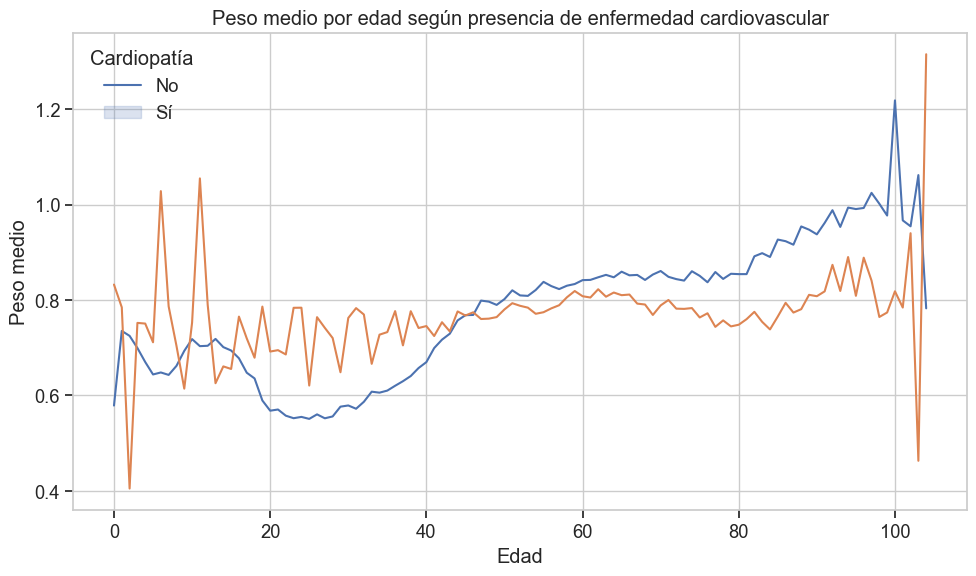

In [175]:
df = data.dropna(subset=['EDAD', 'IR_29301_PESO', 'Cardiovascular'])

media_por_edad = df.groupby(['EDAD', 'Cardiovascular'])['IR_29301_PESO'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_por_edad, x='EDAD', y='IR_29301_PESO', hue='Cardiovascular')

plt.title('Peso medio por edad según presencia de enfermedad cardiovascular')
plt.xlabel('Edad')
plt.ylabel('Peso medio')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

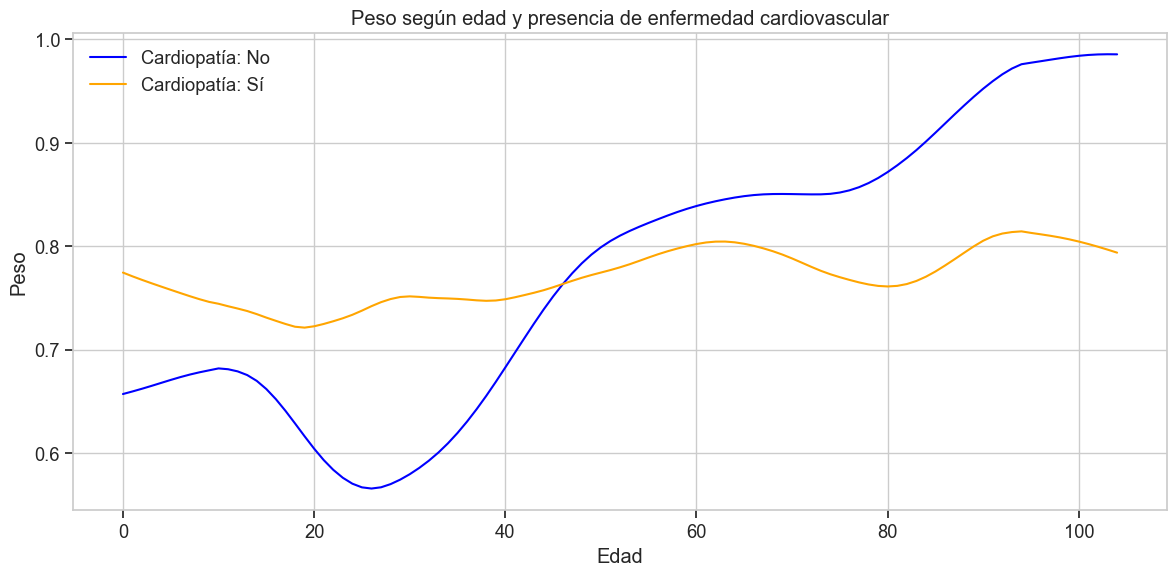

In [176]:

plt.figure(figsize=(12, 6))

Lowess_plot_cardiovascular(media_por_edad, 'EDAD', 'IR_29301_PESO', frac=0.2)

plt.title('Peso según edad y presencia de enfermedad cardiovascular')
plt.xlabel('Edad')
plt.ylabel('Peso')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


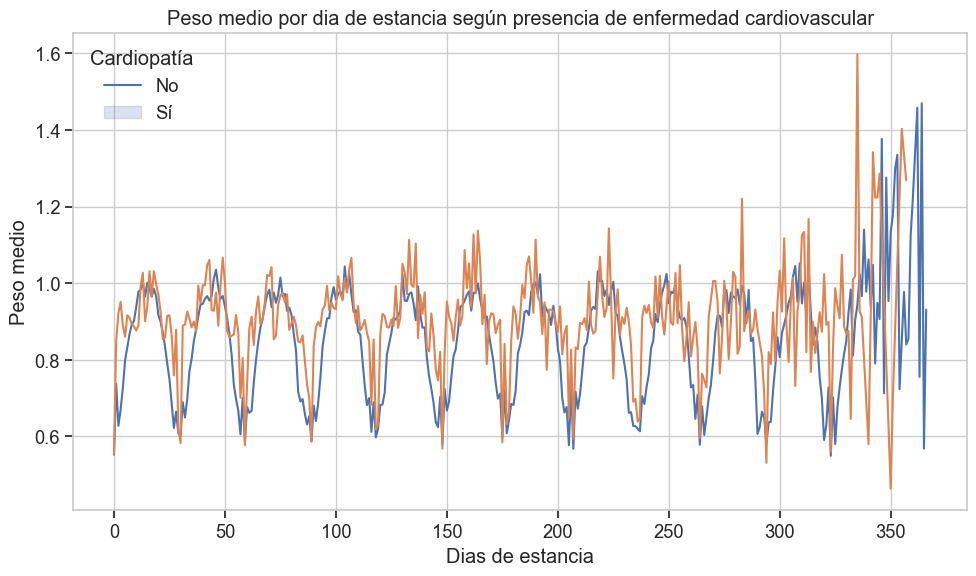

In [177]:
df = data.dropna(subset=['DIAS_ESTANCIA', 'IR_29301_PESO', 'Cardiovascular'])

media_dias_estancia = df.groupby(['DIAS_ESTANCIA', 'Cardiovascular'])['IR_29301_PESO'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_dias_estancia, x='DIAS_ESTANCIA', y='IR_29301_PESO', hue='Cardiovascular')

plt.title('Peso medio por dia de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('Dias de estancia')
plt.ylabel('Peso medio')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [178]:
data.groupby('DIAS_ESTANCIA')['IR_29301_PESO'].agg(['mean', 'std', 'count'])


,mean,std,count
DIAS_ESTANCIA,,,
0,0.552893,0.272448,7582
1,0.754072,0.332726,4545
2,0.657124,0.340956,4746
3,0.701488,0.352133,3792
4,0.745340,0.357245,2070
...,...,...,...
362,1.458400,0.106626,3
363,0.755600,0.175732,3
364,1.470000,NaN,1


<Axes: xlabel='IR_29301_PESO', ylabel='Count'>

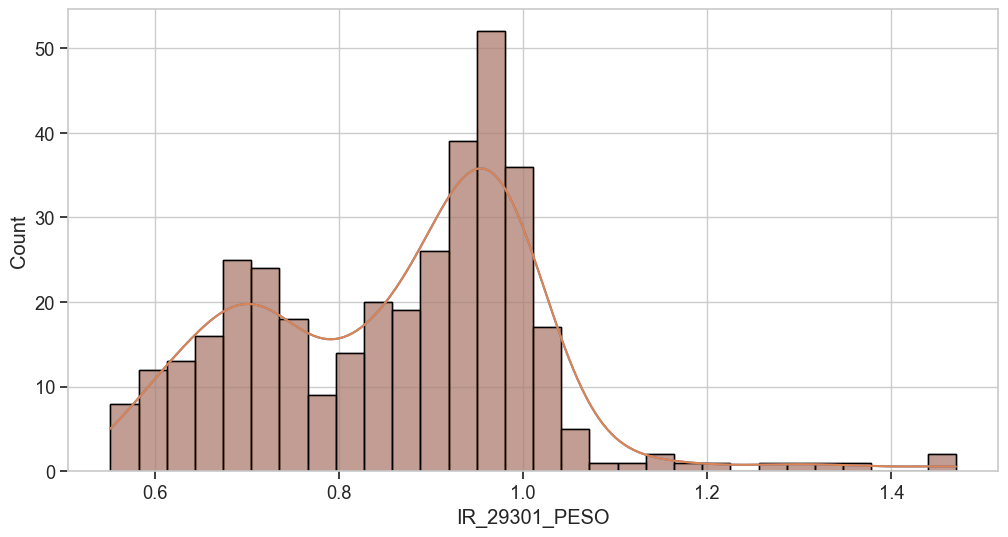

In [179]:
sns.histplot(data_cardio.groupby('DIAS_ESTANCIA')['IR_29301_PESO'].mean(), bins=30, kde=True)
sns.histplot(data_no_cardio.groupby('DIAS_ESTANCIA')['IR_29301_PESO'].mean(), bins=30, kde=True)

<Axes: xlabel='DIAS_ESTANCIA', ylabel='Count'>

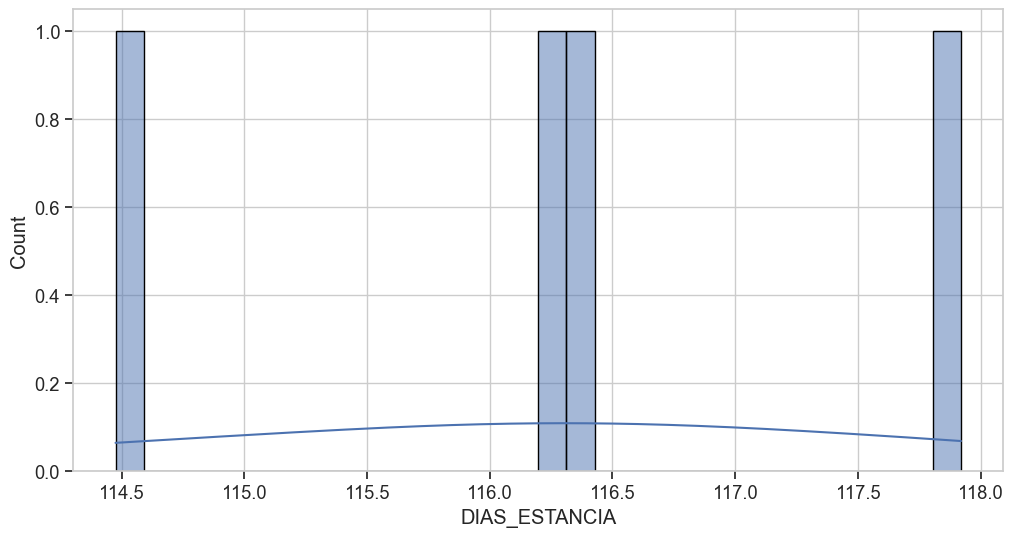

In [180]:
sns.histplot(data.groupby("Rango_Etario")["DIAS_ESTANCIA"].mean(), bins=30, kde=True)

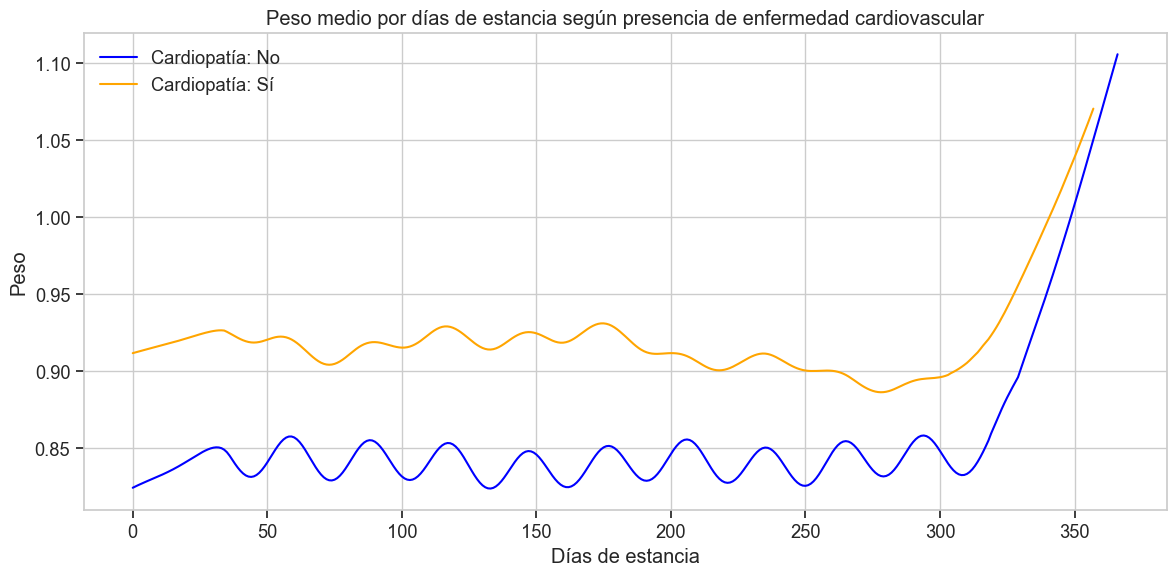

In [181]:
plt.figure(figsize=(12, 6))


Lowess_plot_cardiovascular(media_dias_estancia, 'DIAS_ESTANCIA', 'IR_29301_PESO', frac=0.2)

plt.title('Peso medio por días de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('Días de estancia')
plt.ylabel('Peso')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


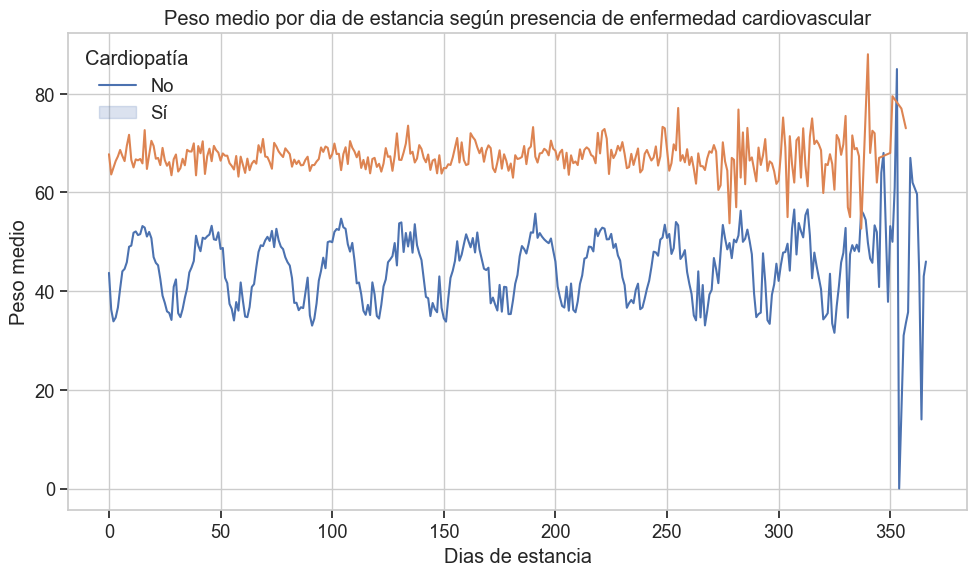

In [182]:
df = data.dropna(subset=['DIAS_ESTANCIA', 'EDAD', 'Cardiovascular'])

media_dias_estancia = df.groupby(['DIAS_ESTANCIA', 'Cardiovascular'])['EDAD'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_dias_estancia, x='DIAS_ESTANCIA', y='EDAD', hue='Cardiovascular')

plt.title('Peso medio por dia de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('Dias de estancia')
plt.ylabel('Peso medio')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

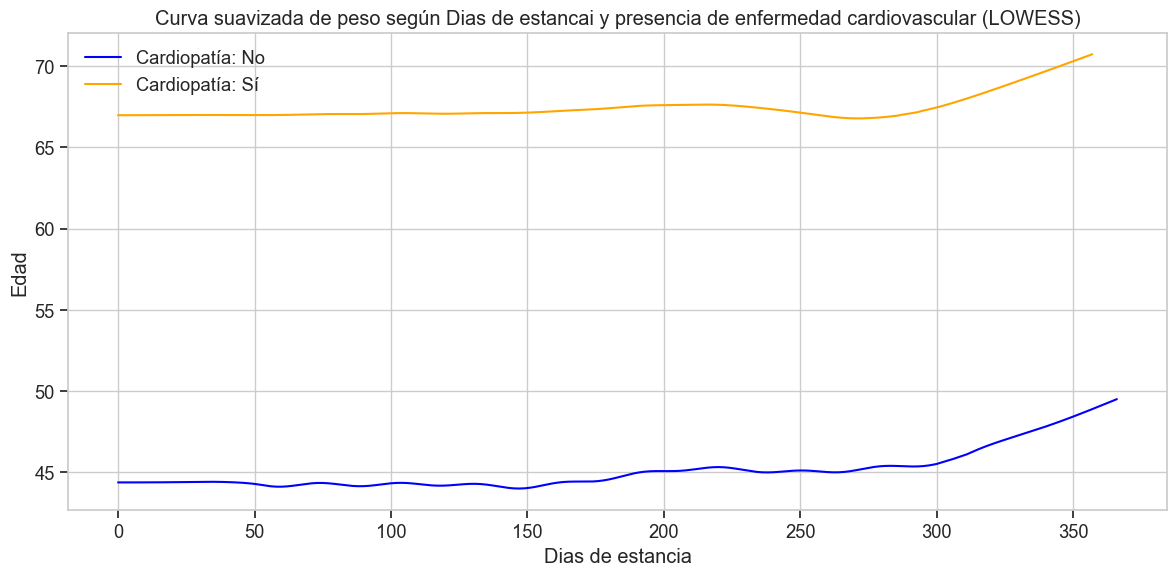

In [183]:
plt.figure(figsize=(12, 6))

Lowess_plot_cardiovascular(media_dias_estancia, 'DIAS_ESTANCIA', 'EDAD', frac=0.3)
plt.title('Curva suavizada de peso según Dias de estancai y presencia de enfermedad cardiovascular (LOWESS)')
plt.xlabel('Dias de estancia')
plt.ylabel('Edad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

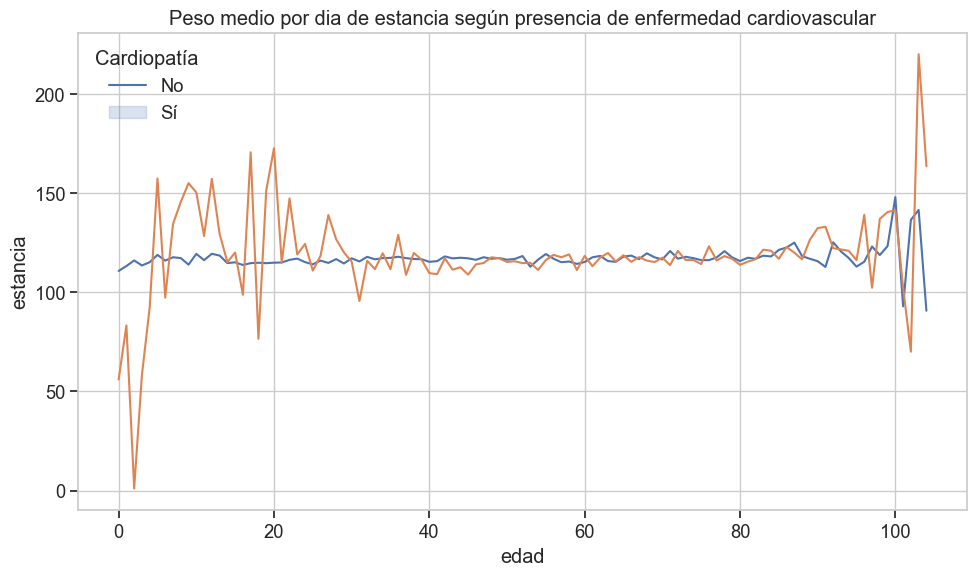

In [184]:
df = data.dropna(subset=['DIAS_ESTANCIA', 'EDAD', 'Cardiovascular'])

media_dias_estancia = df.groupby(['EDAD', 'Cardiovascular'])['DIAS_ESTANCIA'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_dias_estancia, x='EDAD', y='DIAS_ESTANCIA', hue='Cardiovascular')

plt.title('Peso medio por dia de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('edad')
plt.ylabel('estancia')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

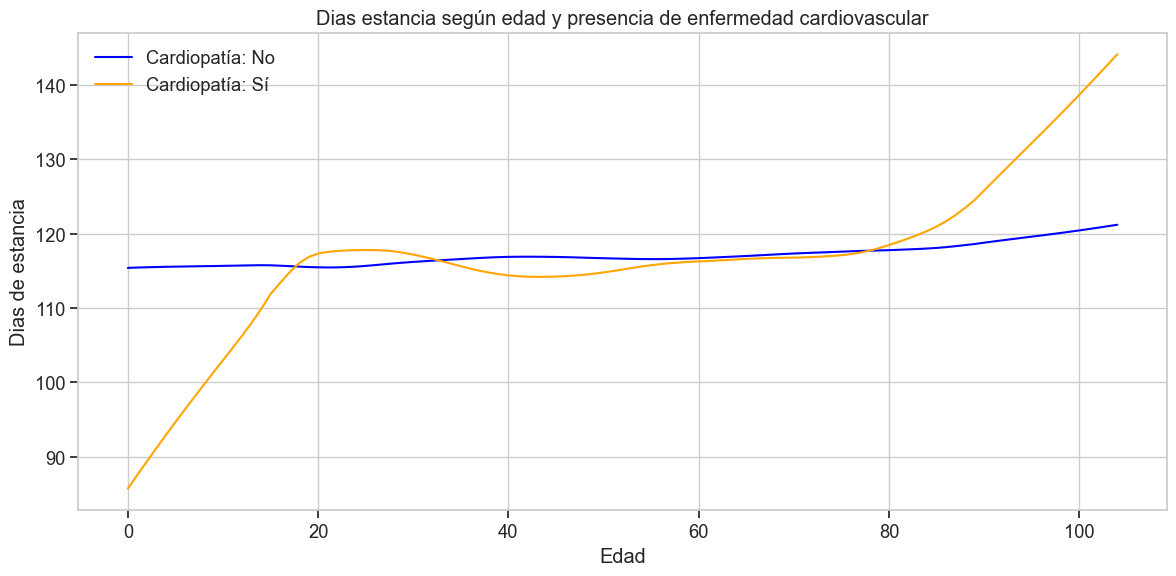

In [185]:
plt.figure(figsize=(12, 6))

Lowess_plot_cardiovascular(media_dias_estancia, 'EDAD', 'DIAS_ESTANCIA', frac=0.3)
plt.title('Dias estancia según edad y presencia de enfermedad cardiovascular')
plt.ylabel('Dias de estancia')
plt.xlabel('Edad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔵 La edad donde comienza el crecimiento pronunciado es aproximadamente: 79.0 años (valor: 112.7036487284385)


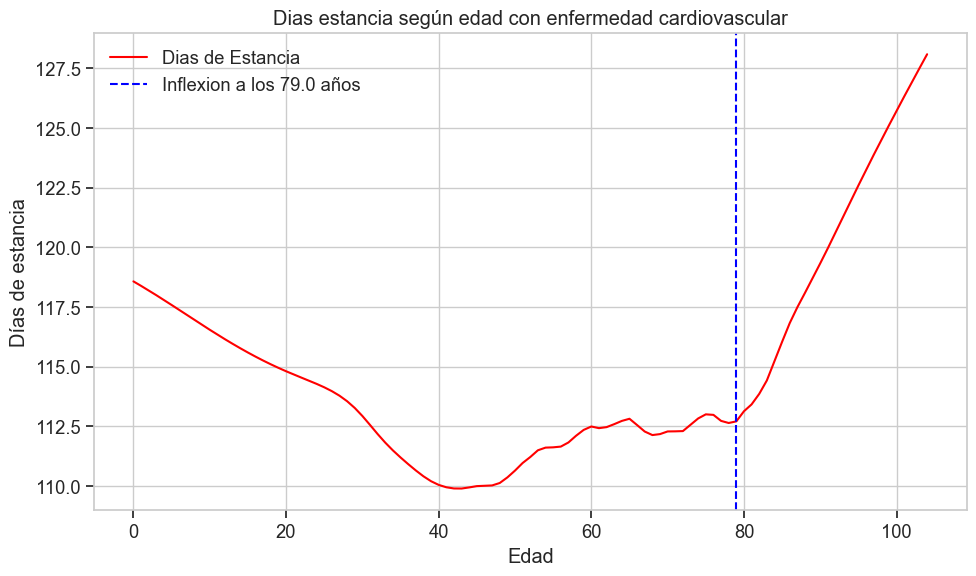

In [186]:
# Subset por grupo con cardiopatía
subset = df[df['Cardiovascular'] == 1]
x = subset['EDAD']
y = subset['DIAS_ESTANCIA']

# LOWESS suavizado
lowess_result = sm.nonparametric.lowess(y, x, frac=0.3, return_sorted=True)
x_smooth = lowess_result[:, 0]
y_smooth = lowess_result[:, 1]

# Eliminar duplicados en x para evitar división por cero
x_unique, idx_unique = np.unique(x_smooth, return_index=True)
y_unique = y_smooth[idx_unique]

# Limita el rango de análisis (ej. entre 60 y 80)
mask = (x_unique >= 60) & (x_unique <= 80)
x_range = x_unique[mask]
y_range = y_unique[mask]

# Primera derivada (pendiente)
dy_dx = np.gradient(y_range, x_range)

# Segunda derivada (cambio de la pendiente)
d2y_dx2 = np.gradient(dy_dx, x_range)

# Encontrar índice donde la segunda derivada es máxima: inicio de crecimiento rápido
inflexion_idx = np.argmax(d2y_dx2)
inflexion_x = x_range[inflexion_idx]
inflexion_y = y_range[inflexion_idx]

print(f"🔵 La edad donde comienza el crecimiento pronunciado es aproximadamente: {inflexion_x} años (valor: {inflexion_y})")

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Dias de Estancia', color='red')
plt.axvline(inflexion_x, color='blue', linestyle='--', label=f'Inflexion a los {inflexion_x} años')
plt.xlabel('Edad')
plt.ylabel('Días de estancia')
plt.title('Dias estancia según edad con enfermedad cardiovascular')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [187]:
df = data.dropna(subset=['EDAD', 'IR_29301_PESO', 'Cardiovascular'])

media_por_edad = df.groupby(['EDAD', 'Cardiovascular'])['IR_29301_PESO'].mean().reset_index()

In [188]:
def Lowess_plot_cardiovascular(df, column1, column2, frac=0.2):
    curves = {}

    for cardiopatia, color, label in zip([0, 1], ['blue', 'orange'], ['No', 'Sí']):
        subset = df[df['Cardiovascular'] == cardiopatia]
        x = subset[column1]
        y = subset[column2]

        lowess_result = sm.nonparametric.lowess(y, x, frac)
        x_lowess, y_lowess = lowess_result[:, 0], lowess_result[:, 1]

        # Store smoothed curves
        curves[cardiopatia] = (x_lowess, y_lowess)

        plt.plot(x_lowess, y_lowess, label=f'Cardiopatía: {label}', color=color)

    return curves


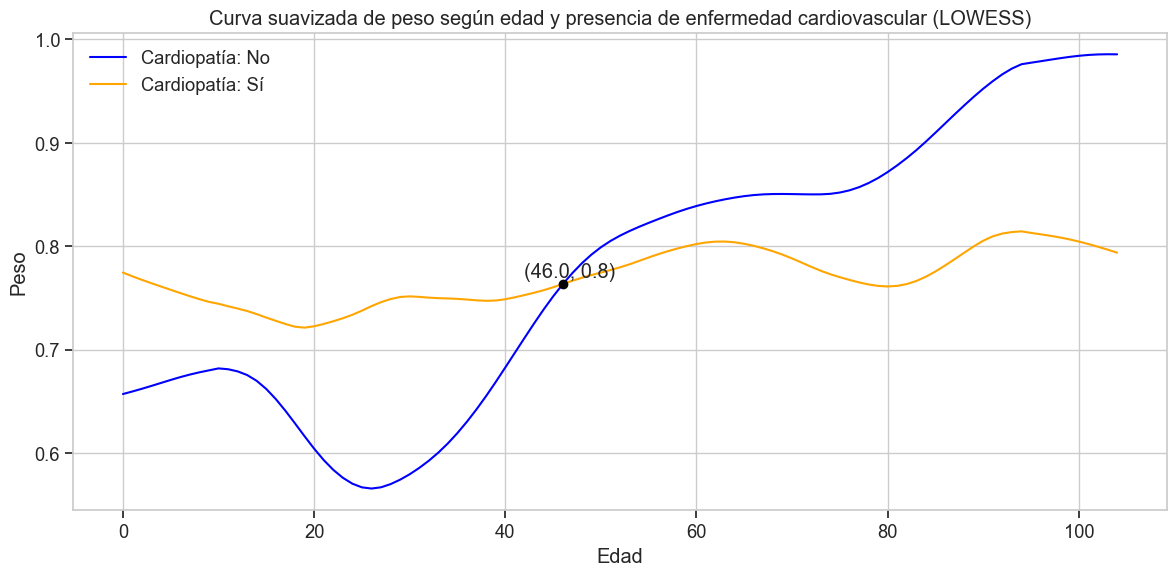

In [189]:
plt.figure(figsize=(12, 6))

# Get the smoothed curves
curves = Lowess_plot_cardiovascular(media_por_edad, 'EDAD', 'IR_29301_PESO', frac=0.2)

# Interpolate both curves on a common x-axis
x_common = np.linspace(
    max(min(curves[0][0]), min(curves[1][0])),
    min(max(curves[0][0]), max(curves[1][0])),
    1000
)
y0_interp = np.interp(x_common, curves[0][0], curves[0][1])
y1_interp = np.interp(x_common, curves[1][0], curves[1][1])

# Find intersection: where the sign of the difference changes
diff = y0_interp - y1_interp
sign_change = np.where(np.diff(np.sign(diff)))[0]

# Plot the intersection point(s)
for idx in sign_change:
    xi = x_common[idx]
    yi = y0_interp[idx]
    plt.plot(xi, yi, 'ko')  # black dot
    plt.annotate(f'({xi:.1f}, {yi:.1f})', (xi, yi), textcoords="offset points", xytext=(5,5), ha='center')

# Show plot
plt.title('Curva suavizada de peso según edad y presencia de enfermedad cardiovascular (LOWESS)')
plt.xlabel('Edad')
plt.ylabel('Peso')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [190]:
data.groupby(['Cardiovascular', 'EDAD'])['IR_29301_PESO'].agg(['mean', 'count', 'median'])


mean  count   median
Cardiovascular EDAD                          
0              0     0.578649  17136  0.53460
               1     0.735135   5214  0.61720
               2     0.724733   3155  0.61720
               3     0.699295   2987  0.58290
               4     0.669897   3097  0.58210
...                       ...    ...      ...
1              100   0.818211      9  0.65720
               101   0.784160      5  0.73980
               102   0.940050      6  1.03260
               103   0.462800      2  0.46280
               104   1.315350      2  1.31535

[210 rows x 3 columns]

In [191]:

data.groupby(['Rango_Etario', 'Cardiovascular'])['IR_29301_PESO'].mean().unstack()


Cardiovascular,0,1
Rango_Etario,,
0-18,0.659360,0.745994
18-40,0.585922,0.739596
40-65,0.796842,0.791187
65-100,0.868038,0.778155


<Axes: xlabel='Rango_Etario', ylabel='IR_29301_PESO'>

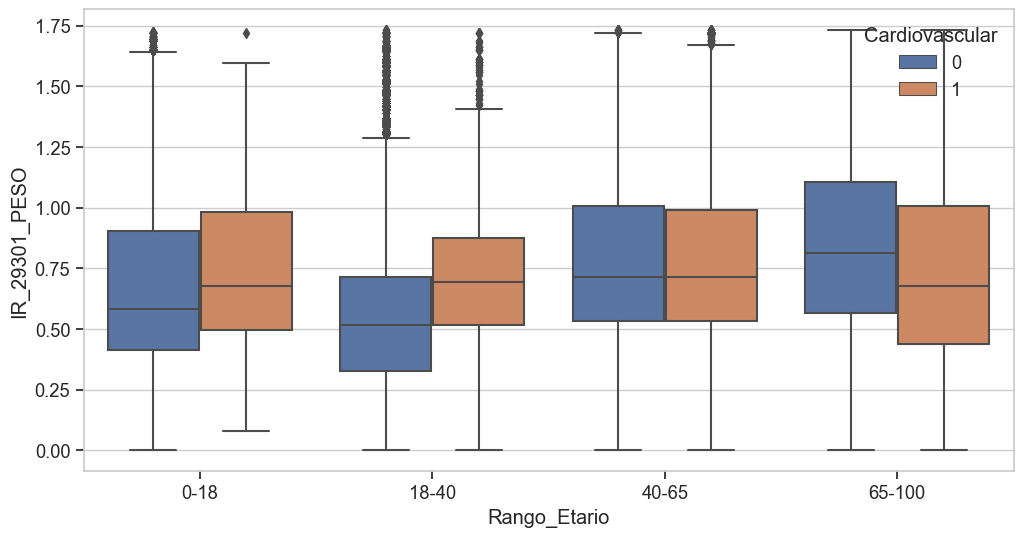

In [192]:
sns.boxplot(data=data, x='Rango_Etario', y='IR_29301_PESO', hue='Cardiovascular')

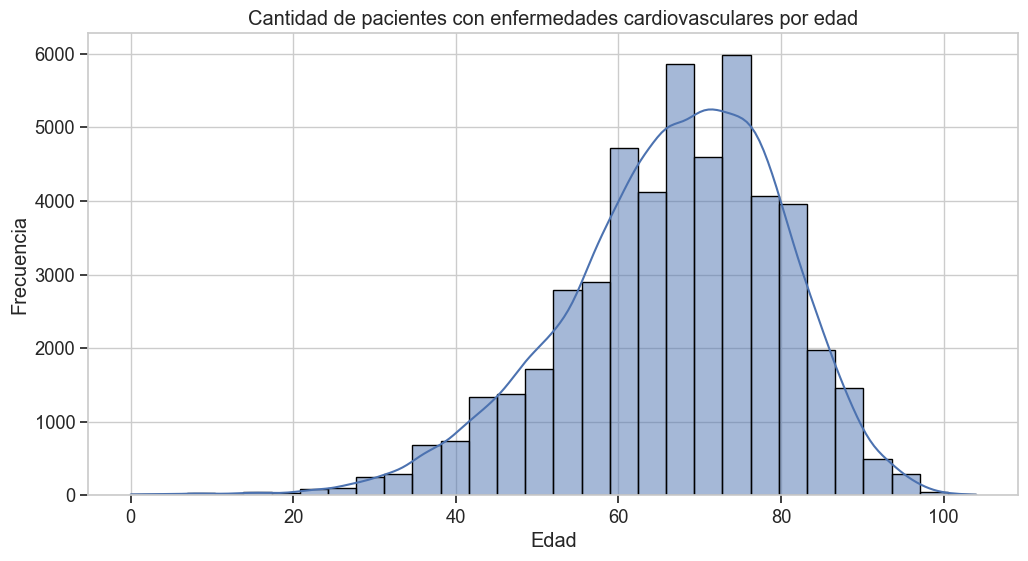

In [193]:
sns.histplot(data[data["Cardiovascular"] == 1]['EDAD'], bins=30, kde=True)
plt.title('Cantidad de pacientes con enfermedades cardiovasculares por edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()


In [194]:
data_cardio

,COD_HOSPITAL,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,PROVINCIA,COMUNA,NACIONALIDAD,PREVISION,SERVICIO_SALUD,TIPO_PROCEDENCIA,...,PROCEDIMIENTO8,PROCEDIMIENTO9,PROCEDIMIENTO10,USOSPABELLON,IR_29301_COD_GRD,IR_29301_PESO,DIAS_ESTANCIA,EDAD,Cardiovascular,Rango_Etario
0,122100,72196813.0,HOMBRE,1980-04-13,VALDIVIA,PANGUIPULLI,CHILE,FONASA INSTITUCIONAL - (MAI) A,VALDIVIA,SERVICIO EMERGENCIA (DOMICILIO),...,99.21,99.18,47.01,NaN,64161.0,0.7094,264,43,0,40-65
1,114101,NaN,HOMBRE,2001-11-04,CORDILLERA,PUENTE ALTO,VENEZUELA (REPÚBLICA BOLIVARIANA DE),PARTICULAR,METROPOLITANO SURORIENTE,SERVICIO EMERGENCIA (DOMICILIO),...,99.21,99.26,99.29,1.0,41301.0,1.0869,213,22,0,18-40
2,114101,97627974.0,HOMBRE,2020-07-30,CORDILLERA,PUENTE ALTO,CHILE,FONASA INSTITUCIONAL - (MAI) A,METROPOLITANO SURORIENTE,"APS URGENCIA (SAPU, SUR, SUC)",...,NaN,NaN,NaN,NaN,44161.0,0.4084,28,2,0,0-18
6,108100,77775513.0,MUJER,2012-11-08,SAN FELIPE,SANTA MARIA,CHILE,FONASA INSTITUCIONAL - (MAI) A,ACONCAGUA,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,1.0,31151.0,0.4106,177,10,0,0-18
7,112102,92070702.0,HOMBRE,2012-05-26,SANTIAGO,LO BARNECHEA,CHILE,FONASA INSTITUCIONAL - (MAI) C,METROPOLITANO ORIENTE,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,1.0,122150.0,0.3642,148,11,0,0-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039573,116105,100083528.0,MUJER,2023-10-05,TALCA,SAN CLEMENTE,CHILE,FONASA INSTITUCIONAL - (MAI) B,DEL MAULE,SERVICIO EMERGENCIA (DOMICILIO),...,NaN,NaN,NaN,NaN,158171.0,0.1055,62,0,0,0-18
1039576,116105,77921830.0,HOMBRE,2012-12-15,TALCA,TALCA,CHILE,FONASA INSTITUCIONAL - (MAI) A,DEL MAULE,SERVICIO EMERGENCIA (DOMICILIO),...,90.32,NaN,NaN,1.0,61131.0,0.7398,262,10,0,0-18
1039577,116105,92173518.0,HOMBRE,2013-08-09,DIGUILLÍN,CHILLAN,CHILE,FONASA INSTITUCIONAL - (MAI) C,ÑUBLE,SERVICIO EMERGENCIA (DOMICILIO),...,NaN,NaN,NaN,1.0,61131.0,0.7398,262,10,0,0-18
1039580,116105,75216538.0,HOMBRE,1949-07-30,TALCA,TALCA,CHILE,FONASA INSTITUCIONAL - (MAI) C,DEL MAULE,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,1.0,22360.0,0.4384,294,74,0,65-100


In [195]:
data_edad_peso = data_cardio[data_cardio['Rango_Etario'] == '65-100'].groupby(['Rango_Etario','DIAGNOSTICO1'])["IR_29301_PESO"].mean().sort_values(ascending=False).reset_index()
data_edad_peso

,Rango_Etario,DIAGNOSTICO1,IR_29301_PESO
0,65-100,M46.25,1.8524
1,65-100,M86.69,1.8524
2,65-100,C10.3,1.8279
3,65-100,H73.8,1.8279
4,65-100,C13.2,1.8279
...,...,...,...
11683,40-65,Z75.3,NaN
11684,40-65,Z76.5,NaN
11685,40-65,Z76.8,NaN
11686,40-65,Z76.9,NaN


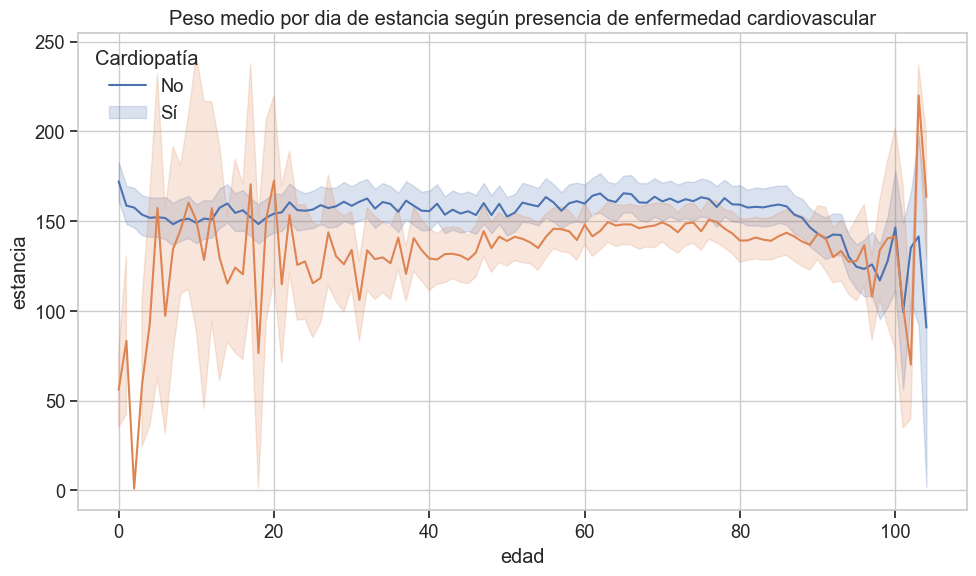

In [205]:
df = data.dropna(subset=['DIAS_ESTANCIA', 'EDAD', 'Cardiovascular', 'IR_29301_PESO'])

media_dias_estancia = df.groupby(['EDAD', 'Cardiovascular', 'DIAS_ESTANCIA'])['IR_29301_PESO'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_dias_estancia, x='EDAD', y='DIAS_ESTANCIA', hue='Cardiovascular')

plt.title('Peso medio por dia de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('edad')
plt.ylabel('estancia')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

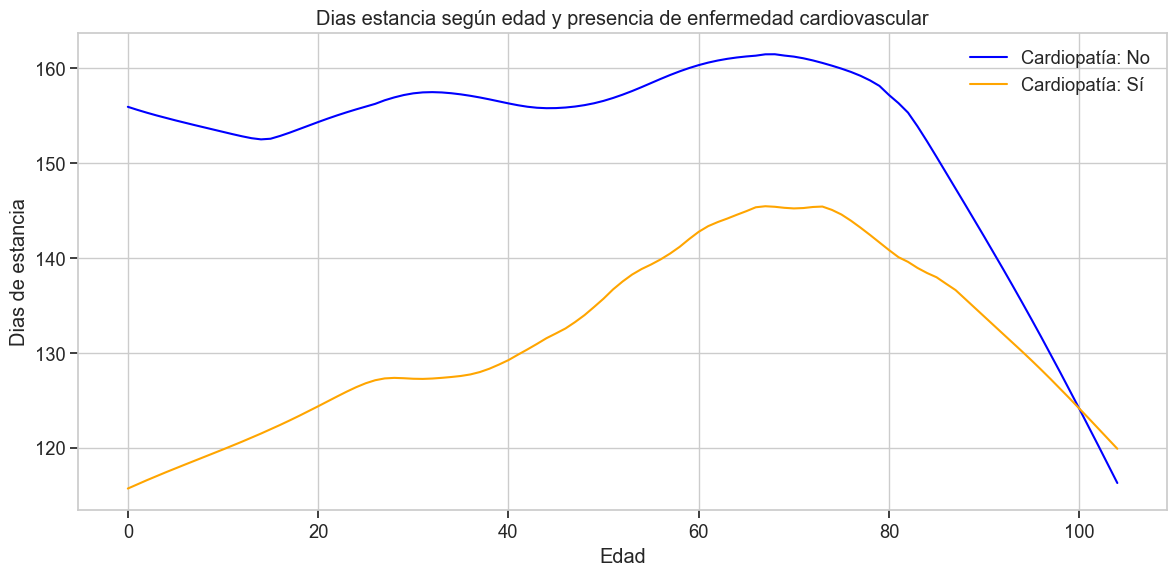

In [206]:
plt.figure(figsize=(12, 6))

Lowess_plot_cardiovascular(media_dias_estancia, 'EDAD', 'DIAS_ESTANCIA', frac=0.3)
plt.title('Dias estancia según edad y presencia de enfermedad cardiovascular')
plt.ylabel('Dias de estancia')
plt.xlabel('Edad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [197]:
# columnas_usar = [
#     'SEXO', 'PROVINCIA', 'NACIONALIDAD', 'PREVISION',
#     'TIPO_PROCEDENCIA', 'TIPO_INGRESO', 'TIPO_ACTIVIDAD',
#     'SERVICIOINGRESO', 'SERVICIOALTA', 'TIPOALTA',
#     'DIAS_ESTANCIA', 'EDAD', 'Multimorbilidad', 'Rango_Etario',
#     'Cardiovascular', 'IR_29301_PESO'
# ]

# df = df_ab_cardio[columnas_usar].copy()
# df = df.dropna()  # Si tienes pocos NaN; si no, puedes imputar

# columnas_categoricas = [
#     'SEXO', 'PROVINCIA', 'NACIONALIDAD', 'PREVISION',
#     'TIPO_PROCEDENCIA', 'TIPO_INGRESO', 'TIPO_ACTIVIDAD',
#     'SERVICIOINGRESO', 'SERVICIOALTA', 'TIPOALTA', 'Rango_Etario'
# ]

# df_match = pd.get_dummies(df, columns=columnas_categoricas, drop_first=True)

# X = df_match.drop(columns=['Cardiovascular', 'IR_29301_PESO'])
# y = df_match['Cardiovascular']



In [198]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler

# # Escalamos X para asegurar convergencia más rápida
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Modelo para estimar propensity scores
# model = LogisticRegression(max_iter=5000)  # aumentamos max_iter
# model.fit(X_scaled, y)
# propensity_scores = model.predict_proba(X_scaled)[:, 1]

# # Aseguramos que df_match tenga el mismo índice que X/y
# df_match = df_match.reset_index(drop=True)
# df_match['propensity_score'] = propensity_scores
# df_match['Cardiovascular'] = y.reset_index(drop=True)

# # Separar tratados y controles
# treated = df_match[df_match['Cardiovascular'] == 1].copy()
# control = df_match[df_match['Cardiovascular'] == 0].copy()

# # Matching usando nearest neighbor (1:1)
# nn = NearestNeighbors(n_neighbors=1)
# nn.fit(control[['propensity_score']])
# distances, indices = nn.kneighbors(treated[['propensity_score']])

# # Obtener controles emparejados por índice
# matched_control = control.iloc[indices.flatten()].copy()
# matched_treated = treated.reset_index(drop=True)

# # Añadir columnas para identificar pares
# matched_control['match_group'] = matched_treated.index
# matched_treated['match_group'] = matched_treated.index

# # Juntar los pares tratados y controles
# matched_df = pd.concat([matched_treated, matched_control], axis=0).sort_values(by="match_group").reset_index(drop=True)

# # matched_df ahora contiene pares tratados-controles emparejados por propensity score


In [199]:
# sns.boxplot(x='Cardiovascular', y='IR_29301_PESO', data=matched_df)
# plt.title("Peso GRD por presencia de enfermedad cardiovascular (Matching)")
# plt.show()

# # Test estadístico
# t_stat, p_val = ttest_ind(
#     matched_df[matched_df['Cardiovascular'] == 1]['IR_29301_PESO'],
#     matched_df[matched_df['Cardiovascular'] == 0]['IR_29301_PESO']
# )

# print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")

In [200]:

# treated = matched_df[matched_df['Cardiovascular'] == 1]['IR_29301_PESO']
# control = matched_df[matched_df['Cardiovascular'] == 0]['IR_29301_PESO']

# # Medias y desviaciones estándar
# mean_treated = np.mean(treated)
# mean_control = np.mean(control)
# std_treated = np.std(treated, ddof=1)
# std_control = np.std(control, ddof=1)

# # Desviación estándar combinada
# n1, n2 = len(treated), len(control)
# pooled_std = np.sqrt(((n1 - 1)*std_treated**2 + (n2 - 1)*std_control**2) / (n1 + n2 - 2))

# # Calcular Cohen's d
# cohen_d = (mean_treated - mean_control) / pooled_std

# print(f"Cohen's d: {cohen_d:.4f}")
